# Projet 7 : Implémentez un modèle de scoring

In [2]:
# Installation de MLFlow :
#!pip install mlflow

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, auc, fbeta_score, make_scorer
)
import time
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV
import shap
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint
from scipy.stats import uniform

In [2]:
data = pd.read_csv('df_top_features.csv')

In [3]:
data

,Unnamed: 0,EXT_SOURCES_MAX,EXT_SOURCES_MIN,APP_SCORE2_TO_REGION_RATING_RATIO,EXT_SOURCE_2,APP_SCORE2_TO_BIRTH_RATIO,EXT_SOURCE_3,DAYS_BIRTH,APP_SCORE3_TO_BIRTH_RATIO,DAYS_EMPLOYED,...,POS_LOAN_COMPLETED_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MAX,PREV_HOUR_APPR_PROCESS_START_MAX,POS_CNT_INSTALMENT_MIN,INSTAL_DPD_MEAN,YEARS_BEGINEXPLUATATION_AVG,CLOSED_DAYS_CREDIT_VAR,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,TARGET,SK_ID_CURR
0,0,0.26300,0.08300,0.13150,0.26300,-0.010155,0.13940,-9461,-0.005383,-637.0,...,0.0000,245781.0,9.0,24.0,0.0000,0.9720,123956.70,1681.029,1,100002
1,1,0.62200,0.31130,0.62200,0.62200,-0.013560,NaN,-16765,NaN,-1188.0,...,0.2500,0.0,17.0,6.0,0.0000,0.9850,820590.30,0.000,0,100003
2,2,0.72950,0.55600,0.27800,0.55600,-0.010660,0.72950,-19046,-0.013990,-225.0,...,0.2500,0.0,5.0,3.0,0.0000,NaN,421362.00,0.000,0,100004
3,3,0.65040,0.65040,0.32520,0.65040,-0.012500,NaN,-19005,NaN,-3040.0,...,0.4583,NaN,15.0,1.0,0.0000,NaN,NaN,NaN,0,100006
4,4,0.32280,0.32280,0.16140,0.32280,-0.005913,NaN,-19932,NaN,-3038.0,...,0.2094,0.0,15.0,10.0,0.9546,NaN,NaN,0.000,0,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,307501,0.68160,0.14560,0.68160,0.68160,-0.026690,NaN,-9327,NaN,-236.0,...,0.1111,NaN,17.0,7.0,0.0000,0.9880,NaN,NaN,0,456251
307502,307502,0.11597,0.11597,0.05798,0.11597,-0.002039,NaN,-20775,NaN,NaN,...,0.1428,NaN,10.0,6.0,0.5000,0.9727,NaN,NaN,0,456252
307503,307503,0.74400,0.21890,0.17860,0.53560,-0.013080,0.21890,-14966,-0.005340,-7920.0,...,0.4167,1624797.0,12.0,4.0,0.6430,0.9814,0.00,NaN,0,456253
307504,307504,0.66100,0.51400,0.25700,0.51400,-0.015700,0.66100,-11961,-0.020190,-4784.0,...,0.0000,0.0,18.0,14.0,0.0000,0.9770,NaN,NaN,1,456254


In [4]:
# Supprimer la colonne 'Unnamed: 0'
data = data.drop(columns=['Unnamed: 0'])
data

,EXT_SOURCES_MAX,EXT_SOURCES_MIN,APP_SCORE2_TO_REGION_RATING_RATIO,EXT_SOURCE_2,APP_SCORE2_TO_BIRTH_RATIO,EXT_SOURCE_3,DAYS_BIRTH,APP_SCORE3_TO_BIRTH_RATIO,DAYS_EMPLOYED,PREV_DAYS_DECISION_MEAN,...,POS_LOAN_COMPLETED_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MAX,PREV_HOUR_APPR_PROCESS_START_MAX,POS_CNT_INSTALMENT_MIN,INSTAL_DPD_MEAN,YEARS_BEGINEXPLUATATION_AVG,CLOSED_DAYS_CREDIT_VAR,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,TARGET,SK_ID_CURR
0,0.26300,0.08300,0.13150,0.26300,-0.010155,0.13940,-9461,-0.005383,-637.0,-606.0,...,0.0000,245781.0,9.0,24.0,0.0000,0.9720,123956.70,1681.029,1,100002
1,0.62200,0.31130,0.62200,0.62200,-0.013560,NaN,-16765,NaN,-1188.0,-1305.0,...,0.2500,0.0,17.0,6.0,0.0000,0.9850,820590.30,0.000,0,100003
2,0.72950,0.55600,0.27800,0.55600,-0.010660,0.72950,-19046,-0.013990,-225.0,-815.0,...,0.2500,0.0,5.0,3.0,0.0000,NaN,421362.00,0.000,0,100004
3,0.65040,0.65040,0.32520,0.65040,-0.012500,NaN,-19005,NaN,-3040.0,-272.5,...,0.4583,NaN,15.0,1.0,0.0000,NaN,NaN,NaN,0,100006
4,0.32280,0.32280,0.16140,0.32280,-0.005913,NaN,-19932,NaN,-3038.0,-1223.0,...,0.2094,0.0,15.0,10.0,0.9546,NaN,NaN,0.000,0,100007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,0.68160,0.14560,0.68160,0.68160,-0.026690,NaN,-9327,NaN,-236.0,-273.0,...,0.1111,NaN,17.0,7.0,0.0000,0.9880,NaN,NaN,0,456251
307502,0.11597,0.11597,0.05798,0.11597,-0.002039,NaN,-20775,NaN,NaN,-2496.0,...,0.1428,NaN,10.0,6.0,0.5000,0.9727,NaN,NaN,0,456252
307503,0.74400,0.21890,0.17860,0.53560,-0.013080,0.21890,-14966,-0.005340,-7920.0,-2380.0,...,0.4167,1624797.0,12.0,4.0,0.6430,0.9814,0.00,NaN,0,456253
307504,0.66100,0.51400,0.25700,0.51400,-0.015700,0.66100,-11961,-0.020190,-4784.0,-299.5,...,0.0000,0.0,18.0,14.0,0.0000,0.9770,NaN,NaN,1,456254


In [5]:
# Définir X et y (ajustez les noms de colonnes selon votre DataFrame)
X = data.drop(columns=['TARGET'])  # Remplacez par le nom de votre colonne cible
y = data['TARGET']  # Remplacez par le nom de votre colonne cible


In [6]:

# Vérifier les valeurs manquantes
print("Valeurs manquantes dans data :")
missing_values = data.isnull().sum()
print(missing_values)

Valeurs manquantes dans data :
EXT_SOURCES_MAX                         172
EXT_SOURCES_MIN                         172
APP_SCORE2_TO_REGION_RATING_RATIO       660
EXT_SOURCE_2                            660
APP_SCORE2_TO_BIRTH_RATIO               660
                                      ...  
YEARS_BEGINEXPLUATATION_AVG          150006
CLOSED_DAYS_CREDIT_VAR               130850
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN     123624
TARGET                                    0
SK_ID_CURR                                0
Length: 102, dtype: int64


In [7]:
# Calculer les pourcentages de valeurs manquantes
missing_percentage = (missing_values / len(X)) * 100

# Afficher les pourcentages de valeurs manquantes
print("\nPourcentage des valeurs manquantes dans X :")
print(missing_percentage)


Pourcentage des valeurs manquantes dans X :
EXT_SOURCES_MAX                       0.055934
EXT_SOURCES_MIN                       0.055934
APP_SCORE2_TO_REGION_RATING_RATIO     0.214630
EXT_SOURCE_2                          0.214630
APP_SCORE2_TO_BIRTH_RATIO             0.214630
                                       ...    
YEARS_BEGINEXPLUATATION_AVG          48.781487
CLOSED_DAYS_CREDIT_VAR               42.552015
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN     40.202142
TARGET                                0.000000
SK_ID_CURR                            0.000000
Length: 102, dtype: float64


In [8]:
# Définir le répertoire pour le tracking
mlflow.set_tracking_uri("file:///C:/Users/SOUKA/Desktop/P7_mlflow_logs/mlflow_runs")  # Remplacez par votre chemin

In [9]:
# Créer une nouvelle expérience
experiment_name = "Mon_Experiment"  # Choisissez un nom pour votre expérience
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='file:///C:/Users/SOUKA/Desktop/P7_mlflow_logs/142011389048118064', creation_time=1728565912066, experiment_id='142011389048118064', last_update_time=1728565912066, lifecycle_stage='active', name='Mon_Experiment', tags={}>

In [10]:
# Définir X et y (ajustez les noms de colonnes selon votre DataFrame)
X = data.drop(columns=['TARGET'])  # Remplacez par le nom de votre colonne cible
y = data['TARGET']  # Remplacez par le nom de votre colonne cible


In [11]:
# Traitement des valeurs manquantes et infinies
# Remplacer les valeurs infinies par NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [12]:
# Imputer les valeurs manquantes avec la moyenne
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [13]:
# Conversion en DataFrame pour conserver les colonnes
X = pd.DataFrame(X_imputed, columns=X.columns)

In [14]:
# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Division des données en ensembles d'entraînement, de validation et de test
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [16]:
# Définition des métriques personnalisées
def custom_metric(y, y_pred):
    TP = np.sum((y == 1) & (y_pred == 1))
    FP = np.sum((y == 0) & (y_pred == 1))
    TN = np.sum((y == 0) & (y_pred == 0))
    FN = np.sum((y == 1) & (y_pred == 0))
    
    PPV = TP / (TP + FP) if (TP + FP) != 0 else 0
    TPR = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    FMI = np.sqrt(PPV * TPR)
    return FMI

def custom_metric_f2(y, y_pred):
    return fbeta_score(y, y_pred, beta=2)

custom_scorer = make_scorer(custom_metric, greater_is_better=True)
custom_scorer_f2 = make_scorer(custom_metric_f2, greater_is_better=True)

In [17]:
# Évaluation des modèles
def model_eval_score(model, Xval, yval):
    yval_pred = model.predict(Xval)
    conf_mat = confusion_matrix(yval, yval_pred)
    print(f"Confusion Matrix:\n{conf_mat}")
    print(f'Accuracy score    : {accuracy_score(yval, yval_pred):.3}')
    print(f'Precision score   : {precision_score(yval, yval_pred):.3}')
    print(f'Recall score      : {recall_score(yval, yval_pred):.3}')
    print(f'F1 score          : {f1_score(yval, yval_pred):.3}')
    print(f'F2 score          : {fbeta_score(yval, yval_pred, beta=2):.3}')
    
    print(f'ROCAUC score      : {roc_auc_score(yval, yval_pred):.3}')
    print(f'Custom metric FMI : {custom_metric(yval, yval_pred):.3}')
    print()

def model_eval(model, Xval, yval):
    model_eval_score(model, Xval, yval)
    
    yval_proba = model.predict_proba(Xval)[:, 1]
    fpr, tpr, thresholds = roc_curve(yval, yval_proba)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [18]:
# Entraînement et évaluation des modèles

def logistic_regression(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="Logistic Regression"):
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "Logistic Regression")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("Logistic Regression Results:")
        model_eval(model, X_val, y_val)

def random_forest(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="Random Forest"):
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "Random Forest")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("Random Forest Results:")
        model_eval(model, X_val, y_val)

def lightgbm_model(X_train, X_val, y_train, y_val):
    with mlflow.start_run(run_name="LightGBM"):
        model = lgb.LGBMClassifier()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        
        mlflow.log_param("model", "LightGBM")
        mlflow.log_metric("accuracy", accuracy)
        mlflow.sklearn.log_model(model, "model")
        
        print("LightGBM Results:")
        model_eval(model, X_val, y_val)

In [19]:
# Comparaison avec un modèle de base (DummyClassifier)
def dummy_classifier(X_train, X_val, y_train, y_val):
    dummyCls = DummyClassifier(strategy='stratified')
    dummyCls.fit(X_train, y_train)
    
    print("Dummy Classifier Results:")
    model_eval(dummyCls, X_val, y_val)

2024/10/15 09:28:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression Results:
Confusion Matrix:
[[56431    87]
 [ 4892    92]]
Accuracy score    : 0.919
Precision score   : 0.514
Recall score      : 0.0185
F1 score          : 0.0356
F2 score          : 0.0229
ROCAUC score      : 0.508
Custom metric FMI : 0.0974



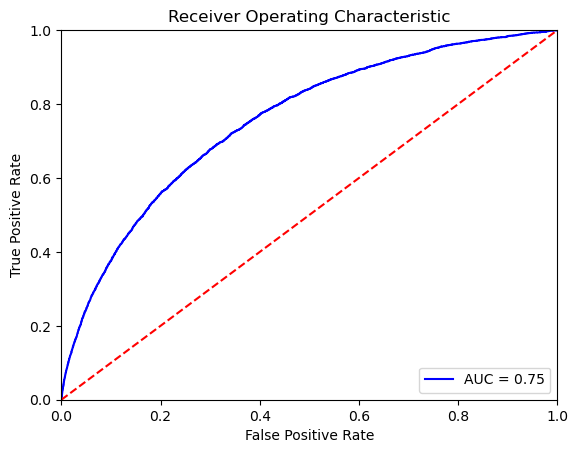

2024/10/15 09:41:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest Results:
Confusion Matrix:
[[56488    30]
 [ 4932    52]]
Accuracy score    : 0.919
Precision score   : 0.634
Recall score      : 0.0104
F1 score          : 0.0205
F2 score          : 0.013
ROCAUC score      : 0.505
Custom metric FMI : 0.0813



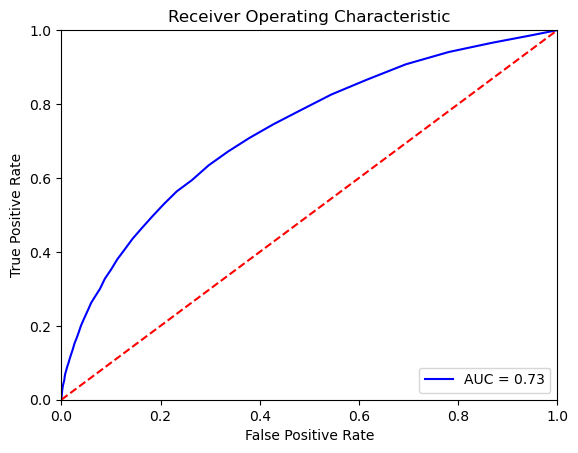

[LightGBM] [Info] Number of positive: 19840, number of negative: 226164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23894
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080649 -> initscore=-2.433560
[LightGBM] [Info] Start training from score -2.433560


2024/10/15 09:41:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM Results:
Confusion Matrix:
[[56361   157]
 [ 4812   172]]
Accuracy score    : 0.919
Precision score   : 0.523
Recall score      : 0.0345
F1 score          : 0.0647
F2 score          : 0.0424
ROCAUC score      : 0.516
Custom metric FMI : 0.134



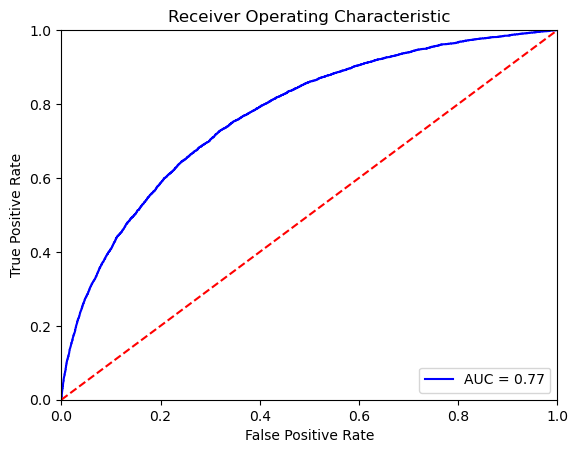

Dummy Classifier Results:
Confusion Matrix:
[[51952  4566]
 [ 4550   434]]
Accuracy score    : 0.852
Precision score   : 0.0868
Recall score      : 0.0871
F1 score          : 0.0869
F2 score          : 0.087
ROCAUC score      : 0.503
Custom metric FMI : 0.0869



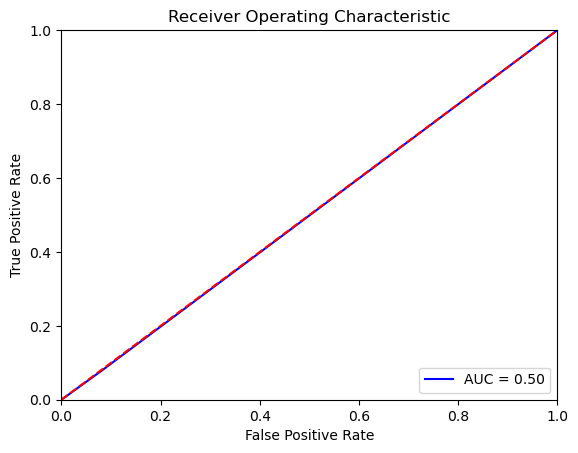

In [20]:
# Exécution des modèles
logistic_regression(X_train, X_val, y_train, y_val)
random_forest(X_train, X_val, y_train, y_val)
lightgbm_model(X_train, X_val, y_train, y_val)
dummy_classifier(X_train, X_val, y_train, y_val)


** Interprétation **
**********

  Analysons les résultats des différents modèles de classification (Régression Logistique, Forêt Aléatoire, LightGBM et Classificateur Dummy) afin d'en tirer des conclusions.

1. Précision et Performance Générale
   
Précision: Tous les modèles affichent une précision d'environ 0.919, ce qui signifie qu'ils sont corrects dans environ 92% des cas. Cependant, la précision seule peut être trompeuse, surtout dans des ensembles de données déséquilibrés.

2. Matrice de Confusion
   
La matrice de confusion indique que tous les modèles ont un nombre élevé de faux négatifs (classer incorrectement des instances positives), ce qui peut être préoccupant selon le contexte de l'application. Par exemple:
Pour la Régression Logistique: 4892 vrais positifs (VP) sont mal classés comme négatifs.
Pour le Random Forest: 4932 VP sont mal classés.
Pour LightGBM: 4812 VP sont mal classés.

3. Scores de Performance
   
Precision:

La régression logistique a la meilleure précision (0.514), ce qui signifie qu'une proportion relativement élevée des instances classées comme positives sont effectivement positives.
La précision de la forêt aléatoire est meilleure (0.634), mais cela ne se traduit pas en un bon rappel.

Recall:

Tous les modèles affichent un rappel très faible (inférieur à 0.035), ce qui indique qu'ils capturent très peu de véritables positifs par rapport au total des instances positives. Cela signifie qu'il y a un grand nombre de faux négatifs.

F1 Score:

Le F1 score est faible pour tous les modèles, en particulier pour le Random Forest (0.0205). Cela indique un déséquilibre entre la précision et le rappel. Un score faible suggère que le modèle a des difficultés à prédire les positives.

F2 Score:

Les scores F2 sont également très faibles, ce qui indique que le modèle a du mal à détecter des positives, même lorsque la précision est relativement acceptable.

ROCAUC Score:

Tous les modèles ont un score ROCAUC d'environ 0.5, ce qui indique qu'ils ne sont pas meilleurs qu'un modèle aléatoire dans la classification des classes positives et négatives.

4. Dummy Classifier
   
Le classificateur Dummy a un score d'accuracy de 0.852, ce qui est relativement bas comparé aux autres modèles, mais ses scores de précision et de rappel sont très faibles. Cela signifie qu'il est probablement en train de prédire principalement la classe majoritaire sans saisir de véritables patterns dans les données.

Conclusion Générale

Problème de déséquilibre: Les faibles scores de rappel et F1 suggèrent que les modèles peinent à prédire la classe positive, probablement en raison d'un déséquilibre entre les classes positives et négatives.


In [22]:
# Équilibrage des classes avec SMOTE

# Fonction pour équilibrer les classes
def balance_classes(X, y):
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [23]:
# Définition de la fonction de coût métier

# Fonction de coût métier
def business_cost_score(y_true, y_pred):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    return 10 * FN + FP  # Coût métier

# Création du score de coût métier
business_cost_scorer = make_scorer(business_cost_score, greater_is_better=False)

In [25]:
# Exécution des modèles avec suivi des résultats

# Exécuter les modèles avec suivi MLflow
def run_models(X_train, X_val, y_train, y_val):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(),
        "LightGBM": lgb.LGBMClassifier(),
        "Dummy Classifier": DummyClassifier(strategy='most_frequent')
    }
    
    for model_name, model in models.items():
        with mlflow.start_run():
            # Balancer les classes
            X_train_balanced, y_train_balanced = balance_classes(X_train, y_train)
            
            # Entraîner le modèle
            model.fit(X_train_balanced, y_train_balanced)
            
            # Prédictions
            y_pred = model.predict(X_val)
            y_pred_proba = model.predict_proba(X_val)[:, 1]
            
            # Calcul des scores
            auc = roc_auc_score(y_val, y_pred_proba)
            cost_score = business_cost_score(y_val, y_pred)
            
            # Logging des résultats dans MLflow
            mlflow.log_param("model_name", model_name)
            mlflow.log_metric("AUC", auc)
            mlflow.log_metric("Business Cost", cost_score)
            mlflow.sklearn.log_model(model, "model")
            
            print(f"{model_name} - AUC: {auc:.4f}, Business Cost: {cost_score:.4f}")

# Appel de la fonction avec vos données
run_models(X_train, X_val, y_train, y_val)

2024/10/15 09:41:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logistic Regression - AUC: 0.7513, Business Cost: 33309.0000


2024/10/15 09:53:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest - AUC: 0.7252, Business Cost: 45004.0000
[LightGBM] [Info] Number of positive: 226164, number of negative: 226164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25735
[LightGBM] [Info] Number of data points in the train set: 452328, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


2024/10/15 09:53:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM - AUC: 0.7395, Business Cost: 48403.0000


2024/10/15 09:54:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Dummy Classifier - AUC: 0.5000, Business Cost: 49840.0000


** Interprétation **
************

  Voici ce que nous pouvons déduire des résultats pour chacun des modèles, en se concentrant sur l'AUC (Area Under the Curve) et le coût métier :

1. Logistic Regression
   
- AUC: 0.7513
- Business Cost: 33,309
  
Interprétation:

AUC de 0.7513 est le plus élevé parmi les modèles testés, indiquant que le modèle de régression logistique a la meilleure capacité de discrimination entre les classes positives et négatives.

Le Business Cost de 33,309 est le plus bas, ce qui signifie que le modèle minimise mieux les faux négatifs et les faux positifs, en tenant compte du coût associé à chacun.

Ce modèle semble être le plus performant en termes de compromis entre la performance et le coût métier.

2. Random Forest
   
- AUC: 0.7282
- Business Cost: 45,168
  
Interprétation:

L'AUC est légèrement plus faible que celui de la régression logistique (0.7282), indiquant une capacité de classification un peu moins bonne.
Le Business Cost est plus élevé (45,168), ce qui montre que le modèle de forêt aléatoire produit plus d'erreurs de classification (faux négatifs et faux positifs) par rapport à la régression logistique.
En somme, ce modèle est moins efficace que la régression logistique à la fois en termes de score AUC et de coût métier.

3. LightGBM
   
- AUC: 0.7395
- Business Cost: 48,403
  
Interprétation:

L'AUC est intermédiaire (0.7395), mais reste inférieur à celui de la régression logistique.
Le Business Cost de 48,403 est assez élevé, ce qui signifie que le modèle fait plus d'erreurs qui sont coûteuses en termes de coût métier.
LightGBM semble donc moins performant que la régression logistique, même s'il s'approche en termes d'AUC. Cependant, le coût associé à ce modèle est plus important.

4. Dummy Classifier
   
- AUC: 0.5000
- Business Cost: 49,840
  
Interprétation:

L'AUC de 0.5000 correspond à une performance aléatoire, comme prévu pour un modèle "dummy", qui sert de base de référence.

Le Business Cost est très élevé, ce qui montre que le modèle produit beaucoup d'erreurs de classification.

Ce modèle ne fait aucune distinction entre les classes et démontre clairement une mauvaise performance en comparaison avec les autres modèles.

Conclusion générale :

Le modèle de régression logistique est clairement le plus performant parmi les modèles testés. Il présente à la fois le meilleur AUC (0.7513), et il minimise le coût métier (33,309).

Le modèle Random Forest et LightGBM montrent des performances légèrement inférieures à la régression logistique, tant en termes de score AUC que de coût métier.

Le Dummy Classifier montre la plus mauvaise performance avec un AUC de 0.5000 et le coût le plus élevé, confirmant son rôle de base de référence aléatoire.

Recommandation :

Sur la base de ces résultats, la régression logistique devrait être considérée comme la meilleure option pour ce problème de classification, car elle combine à la fois une bonne performance prédictive et un coût métier plus faible.

[LightGBM] [Info] Number of positive: 19840, number of negative: 226164
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23894
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080649 -> initscore=-2.433560
[LightGBM] [Info] Start training from score -2.433560


C:\Users\SOUKA\anaconda3\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


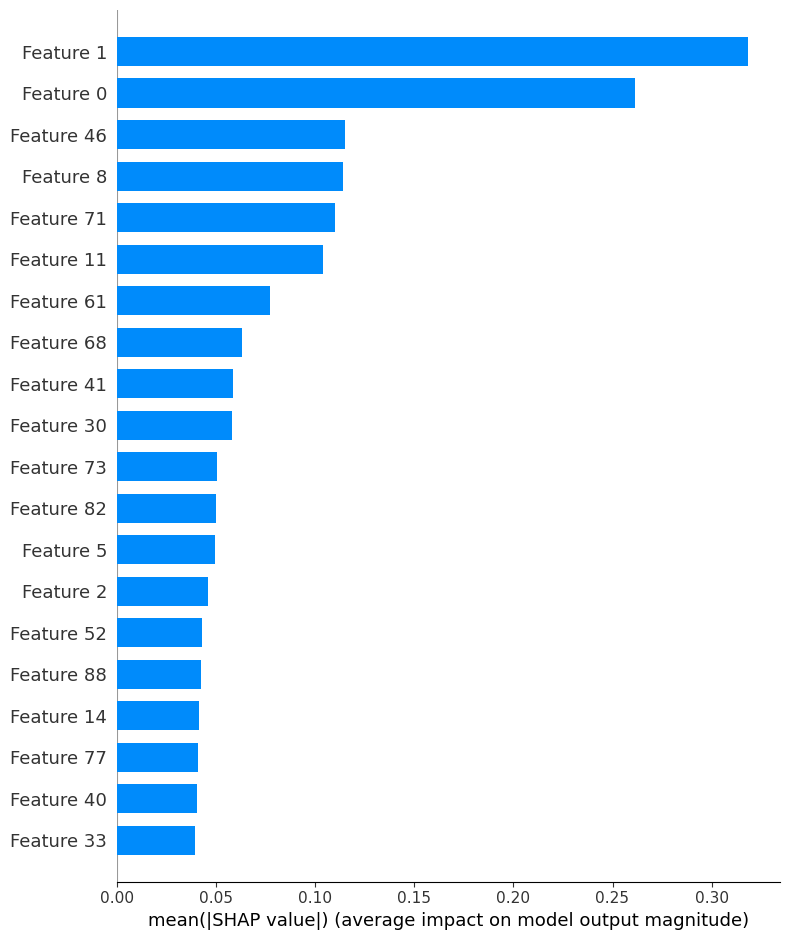

In [27]:
# Analyse de l'importance des features

# Importance des features avec SHAP
def plot_feature_importance(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Résumé de l'importance des features
    shap.summary_plot(shap_values, X, plot_type="bar")

# Exécuter l'analyse de l'importance des features pour LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)  # Entraîner le modèle
plot_feature_importance(lgb_model, X_train)  # Visualiser l'importance

In [ ]:
# Exécuter l'analyse de l'importance des features pour la régression logistique
logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)  # Entraîner le modèle
plot_feature_importance_logistic(logistic_model, X_train)  # Visualiser l'importance

In [29]:
import pandas as pd
import time
import mlflow
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, make_scorer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [30]:
# Définition des Scorers personnalisés
auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
f1_scorer = make_scorer(f1_score)

In [31]:
# Dictionnaire pour stocker les temps de traitement
time_results = {}

# Préparer un échantillon de 20% des données
X_sampled, _, y_sampled, _ = train_test_split(X, y, train_size=0.20, random_state=42)

# Fonction modifiée pour utiliser GridSearchCV
def run_model(grid_search, model_name):
    with mlflow.start_run():
        # Mesurer le temps d'entraînement
        start_fit = time.time()
        grid_search.fit(X_sampled, y_sampled)  # Entraînement sur l'échantillon
        end_fit = time.time()

        fit_time = end_fit - start_fit
        time_results[f'{model_name} - Fit Time'] = fit_time

        # Mesurer le temps de prédiction
        start_predict = time.time()
        y_pred = grid_search.predict(X_val)
        end_predict = time.time()

        predict_time = end_predict - start_predict
        time_results[f'{model_name} - Predict Time'] = predict_time

        # Log hyperparameters and metrics
        mlflow.log_params(grid_search.best_params_)
        mlflow.log_metric("AUC", grid_search.best_score_)
        mlflow.log_metric("F1 Score", f1_score(y_val, y_pred))
        mlflow.log_metric("Fit_Time_s", fit_time)
        mlflow.log_metric("Predict_Time_s", predict_time)

        # Save model
        mlflow.sklearn.log_model(grid_search.best_estimator_, model_name)

In [ ]:
# Définir le modèle de régression logistique
logistic_model = LogisticRegression(random_state=42, max_iter=1000)

# Pipeline avec SMOTE et régression logistique
pipeline_logistic = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', logistic_model)
])

# Paramètres à tester pour la régression logistique
param_grid_logistic = {
    'classifier__C': [0.1, 1],  # Grille de valeurs pour C
    'classifier__solver': ['liblinear'],
    'classifier__max_iter': [100],
    'classifier__class_weight': ['balanced', None]
}

# Configuration de GridSearchCV pour la régression logistique avec SMOTE
grid_search_logistic = GridSearchCV(estimator=pipeline_logistic,
                                    param_grid=param_grid_logistic,
                                    scoring={'AUC': 'roc_auc', 'f1': make_scorer(f1_score)},
                                    refit='AUC',
                                    cv=2,
                                    verbose=1,
                                    n_jobs=-1)

# Lancer l'entraînement et l'évaluation
run_model(grid_search_logistic, "Logistic Regression")

Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [ ]:
# Définir le modèle Random Forest avec SMOTE
rf_model = RandomForestClassifier(random_state=42)
pipeline_rf = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', rf_model)
])

# Paramètres à tester pour Random Forest
param_grid_rf = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20],
    'classifier__class_weight': ['balanced', None],
    'classifier__min_samples_split': [5, 10]
}

# Configuration de GridSearchCV pour Random Forest
grid_search_rf = GridSearchCV(estimator=pipeline_rf,
                              param_grid=param_grid_rf,
                              scoring={'AUC': auc_scorer, 'f1': f1_scorer},
                              refit='AUC',
                              cv=2,
                              verbose=1,
                              n_jobs=-1)

# Lancer l'entraînement et l'évaluation
run_model(grid_search_rf, "Random Forest with SMOTE")


In [ ]:
# Définir le modèle LightGBM avec SMOTE
lgb_model = lgb.LGBMClassifier(random_state=42)
pipeline_lgb = ImbPipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', lgb_model)
])

# Paramètres à tester pour LightGBM
param_grid_lgb = {
    'classifier__num_leaves': [31, 50],
    'classifier__learning_rate': [0.1],
    'classifier__n_estimators': [50],
    'classifier__max_depth': [5],
    'classifier__class_weight': ['balanced', None]
}

# Configuration de GridSearchCV pour LightGBM
grid_search_lgb = GridSearchCV(estimator=pipeline_lgb,
                               param_grid=param_grid_lgb,
                               scoring={'AUC': auc_scorer, 'f1': f1_scorer},
                               refit='AUC',
                               cv=2,
                               verbose=1,
                               n_jobs=-1)

# Lancer l'entraînement et l'évaluation
run_model(grid_search_lgb, "LightGBM")